In [1]:
#Llamado de módulos y cargue de archivo de texto con Tweets

import pandas as pd
import re
import unicodedata2
import nltk
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
import string
from nltk.stem import SnowballStemmer
import sklearn;
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import tokenize
from string import digits
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.metrics.pairwise import polynomial_kernel
from xml.dom import minidom
import numpy as np
import math

df = pd.read_csv('ScoreV0.csv')
#,encoding = "ISO-8859-1")

In [2]:
#El archivo stopwords, permite hacer una impieza en el texto, eliminando palabras de unión como y, de, en, etc'''
import pandas as pd
import numpy as np
%matplotlib inline
import random
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

sw = stopwords.words('spanish')

In [3]:
#   Definicion de funciones para arreglar texto

#   remove_punct: elimina la puntuación

def remove_punct(strin):
    strin = strin.translate(str.maketrans('','',string.punctuation));
    strin = strin.translate(str.maketrans('','',string.digits));
    return strin;
    
#   normunicode_data: Normalizar: eliminar diéresis, acentos, y otros caracteres similares.
        
def normunicode_data(strin):
    #print(strin)
    return unicodedata2.normalize('NFKD', strin).encode('ASCII', 'ignore').decode("utf-8").lower()


#   tok_cln: Tokeniza las palabras y remueve las stopwords


def tok_cln(strin):
    return set(nltk.wordpunct_tokenize(strin)).difference(sw)
    #return set(nltk.wordpunct_tokenize(strin))
    

#   stemm_data: Corta a la raiz las palabras

def stemm_data(strin):
    stemmer = SnowballStemmer("spanish");
    return stemmer.stem(strin)  

In [4]:
def proc_str(strin):
    return remove_punct(normunicode_data(strin));

def proc_string(strin,setData):
    resp = set([]);
    for data in tok_cln(proc_str(strin)):
        tm  = stemm_data(data)
        resp.add(tm)
        if tm in setData:
            setData[tm].add(data)
        else:
            setData[tm] = set([data])
    return ', '.join(resp);

In [5]:
def df2tdm(df,titleColumn,setData):
    listData = [];
    for idx in df.index:        
        listData.append(proc_string(df[titleColumn][idx],setData));
    return listData;

# tf-idf:term frequency–inverse document frequency
# Se vectoriza y se produce la matriz tf-idf
def getDictionary(dfpp): 
    setData = {}
    stinProc = df2tdm(dfpp,'full_text',setData);
    cv = TfidfVectorizer();    
    cv_fit = cv.fit_transform(stinProc);       
    cvCount = TfidfVectorizer(cv.vocabulary_);
    # computes the vectorial representation of the CIE10    
    cv_fitCount = cvCount.fit_transform(stinProc);        
    features = cvCount.get_feature_names();    
    return cv,cv_fitCount,features,setData

In [6]:
#top_tfidf_feats: toma una sola fila de la matriz tf-idf --correspondiente a un documento en particular--, 
#y devuelve las n palabras con la puntuación más alta --o más generalmente tokens o características.

def top_tfidf_feats(row, features, top_n=25):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def plot_tfidf_classfeats_OrigWords(dfs,setData):
    strTotal = [];
    for i, df in enumerate(dfs):
        print('=============================================================================================')
        for k  in df.feature:
            print(k + ' >> ' + str(setData[k]))                        
            st =  "";
            for j in setData[k]:
                st = st + j + " ";                
            strTotal.append(st);
    return strTotal;

In [7]:
#Grafica los tfidf. 
def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [8]:
# Se calcula el puntaje promedio tf-idf de todas las palabras 
# es decir, el promedio por columna de una matriz tf-idf:
    
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)    

#Se calculan las puntuaciones medias de tf-idf según la etiqueta de clase: "Seguro/No Seguro" 
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

#Grafica los valores de intersección y diferencia entre ambos sets de palabras (Seguras y no seguras)
def computeInterAndDiff(dfs1,dfs2):
    vec1 = [];
    
    for i, df in enumerate(dfs1):                
        v1 = df['feature'].values;

    for i, df in enumerate(dfs2):
        v2 = df['feature'].values;                    
    
    print('Words in the interesection');
    print(set(v1).intersection(set(v2)))
    print('Words in \"Seguro\" but no in \"No Seguro\"');
    print(set(v1)-set(v2))
    print('Words in \"No Seguro\" but no in \"Seguro\"');
    print(set(v2)-set(v1))

In [22]:
#Se corre el analisis para la tokenización
#y la obtención del corpus, se realizan las graficas para cada tipo de agrupación y para el total

def runAnalysis(valTopn):
    dfpp = df[df['class'].isin(['Seguro','No Seguro'])]
    cvQuery_fit,cv_fitCount,features,origTerms = getDictionary(dfpp)
    dfs = top_feats_by_class(cv_fitCount, dfpp['class'], features, top_n=valTopn);
    strWordsComplete = plot_tfidf_classfeats_OrigWords(dfs,origTerms)
    plot_tfidf_classfeats_h(dfs)

    dfpp = df[df['class']=='No Seguro']
    cvQuery_fit,cv_fitCount,features,origTerms = getDictionary(dfpp)
    dfs1 = top_feats_by_class(cv_fitCount, dfpp['class'], features, top_n=valTopn);
    strWordsCompletePnP = plot_tfidf_classfeats_OrigWords(dfs1,origTerms)
    plot_tfidf_classfeats_h(dfs1)

    dfpp = df[df['class']=='Seguro']
    cvQuery_fit,cv_fitCount,features,origTerms = getDictionary(dfpp)
    dfs2 = top_feats_by_class(cv_fitCount, dfpp['class'], features, top_n=valTopn);
    strWordsCompletePP = plot_tfidf_classfeats_OrigWords(dfs2,origTerms)
    plot_tfidf_classfeats_h(dfs2)
    
    computeInterAndDiff(dfs1,dfs2);
    
    return (strWordsComplete,strWordsCompletePnP,strWordsCompletePP);

In [9]:
def vector2String(dfs):
    
    for i, df in enumerate(dfs):                
        v1 = df['feature'].values;
    
    strPos = "";
    for i in v1:
        print(i)
        strPos = strPos + " " + i;
    return strPos; 
    
def word_feats(words):    
    return dict([(word, True) for word in words])

def procWord(strin):
    return stemm_data(proc_str(strin));

def getVocab(fileName):
    positive_vocab = [];    
    negative_vocab = [];    
    xmldoc = minidom.parse(fileName)
    itemlist = xmldoc.getElementsByTagName('senticon')
    for s in itemlist[0].getElementsByTagName('layer'):    
        for pl in s.getElementsByTagName('positive'):
            for pll in pl.getElementsByTagName('lemma'):                
                positive_vocab.append([pll.firstChild.nodeValue.replace(" ", ""),float(pll.getAttribute('pol'))]);
        for pl in s.getElementsByTagName('negative'):
            for pll in pl.getElementsByTagName('lemma'):             
                negative_vocab.append([pll.firstChild.nodeValue.replace(" ", ""),float(pll.getAttribute('pol'))]);
    return (positive_vocab,negative_vocab)

In [10]:
##Cuenta las ocurrencias de las palabras negativas y positivas
def getScoreSentiment(words,posText,posScore,negText,negScore,optionScore):  
    countTotalScore = 0;        
    for word in words:                        
        if len(word)>0:
            indicesPos = [i for i, x in enumerate(posText) if word in x.split('_')]
            indicesNeg = [i for i, x in enumerate(negText) if word in x.split('_')]
#             indicesPos = [i for i, x in enumerate(posText) if word == x]
#             indicesNeg = [i for i, x in enumerate(negText) if word == x]
            cvalP = 0;
            for j in indicesPos:
                if optionScore==0:                
                    cvalP += 1;
                if optionScore==1:
                    cvalP += posScore[j];
                #break
                                    
            cvalN = 0;
            for k in indicesNeg:                 
                if optionScore==0:
                    cvalN -= 1;
                if optionScore==1:
                    cvalN += negScore[k];
                #break
                        
#             if (len(indicesNeg)+len(indicesPos))>0:
#                 cval = cval/(len(indicesNeg)+len(indicesPos));            

#             countTotalScore+=(cvalP+cvalN);
            if (len(indicesNeg)+len(indicesPos))>0:
                countTotalScore+=(cvalP+cvalN)/(len(indicesNeg)+len(indicesPos));
                
#             if (len(indicesNeg))>0:
#                 countTotalScore+=(cvalN)/(len(indicesNeg));
#             if (len(indicesPos))>0:
#                 countTotalScore+=(cvalP)/(len(indicesPos));

    return countTotalScore;

#Calcula los scores para el diccionario
def computeSentimentScoresDictionary(strWords,posText,posScore,negText,negScore,optionScore):
    vecScoreSentimentDictionary = [];
    for idx in strWords:        
        scv = getScoreSentiment(idx.split(' '),posText,posScore,negText,negScore,optionScore);
        vecScoreSentimentDictionary.append(scv)        
    df = pd.DataFrame({'Terms':strWords, 'Sentiment Score':vecScoreSentimentDictionary});    
    return (vecScoreSentimentDictionary,df);

In [12]:
#Analisis de sentimientos, teniendo los textos considerados positivos y su score
#de igual forma los negativos
def runAnalysisWithSentiment(sizeDict,posText,posScore,negText,negScore,optionScore):
    vecScoreSentimentDictionary = [];    
    (strWordsComplete,strWordsCompletePnP,strWordsCompletePP) = runAnalysis(sizeDict);
    (scoresComplete,dfComplete) = computeSentimentScoresDictionary(strWordsComplete,posText,posScore,negText,negScore,optionScore);
    (scoresPP,dfCompletePP) = computeSentimentScoresDictionary(strWordsCompletePP,posText,posScore,negText,negScore,optionScore);
    (scoresPnP,dfCompletePnP) = computeSentimentScoresDictionary(strWordsCompletePnP,posText,posScore,negText,negScore,optionScore);
    df1 = pd.DataFrame({'Dictionary': 'Score complete', 'Sentiment Score': scoresComplete})
    df2 = pd.DataFrame({'Dictionary': 'Score Seguro', 'Sentiment Score': scoresPP})
    df3 = pd.DataFrame({'Dictionary': 'Score No Seguro', 'Sentiment Score': scoresPnP})
    frames = [df1, df2, df3]
    result = pd.concat(frames)    
    sns.violinplot(x="Dictionary", y="Sentiment Score", data=result);
    sns.swarmplot(x="Dictionary", y="Sentiment Score", data=result, color="w", alpha=.5);
    print('Dictionary Complete')
    print(dfComplete)
    print('Dictionary Seguro')
    print(dfCompletePP)
    print('Dictionary No Seguro')
    print(dfCompletePnP)
    
(positive_vocab,negative_vocab) = getVocab('senticon.es.xml');

dfpp = df[df['class'].isin(['Seguro','No Seguro'])]

posText = [row[0] for row in positive_vocab];
posScore = [row[1] for row in positive_vocab];
negText = [row[0] for row in negative_vocab];
negScore = [row[1] for row in negative_vocab];

# Analisis de sentimiento para los tweets
vecScoreSentimentSimple = [];
vecScoreSentimentPolarity = [];

for idx in dfpp.index:
    wordsOpinion = [];    
    for data in tok_cln(proc_str(dfpp['Tweet'][idx])):
        tm  = data
        wordsOpinion.append(tm)                    
    vecScoreSentimentSimple.append(getScoreSentiment(wordsOpinion,posText,posScore,negText,negScore,0))        
    vecScoreSentimentPolarity.append(getScoreSentiment(wordsOpinion,posText,posScore,negText,negScore,1))    
    
    
# Analisis de sentimiento para los diccionarios
optionScore = 0;
runAnalysisWithSentiment(25,posText,posScore,negText,negScore,optionScore);
runAnalysisWithSentiment(50,posText,posScore,negText,negScore,optionScore);


KeyError: 'class'

In [13]:
from sklearn.metrics import confusion_matrix
import itertools
#  Esta función imprime y traza la matriz de confusión.
#La normalización se puede aplicar estableciendo `normalize = True`.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm=cm.astype('float');
        vecRes = cm.sum(axis=1)
        for i in range(vecRes.shape[0]):
            if vecRes[i] != 0.0:                
                cm[i]=cm[i]/vecRes[i];                            
    else:
        print('Confusion matrix, without normalization')    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if ~np.isnan(cm[i, j]):            
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label by sentiment analysis')


In [27]:
#Calculo de los scores por clase
def computeScoreClass(dfppT,labelVal):    
    va = (dfppT['Sentiment Score']>0);
    vb = (dfppT['class']==labelVal);
    out = ((va & vb)|((~va) & (~vb)));
    return out

<ipython-input-28-2c6748799ead>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfppT['Sentiment Score'] = pd.Series(vecScoreSentimentT, index=dfppT.index)


Confusion matrix, without normalization


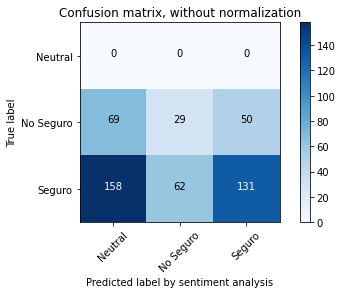

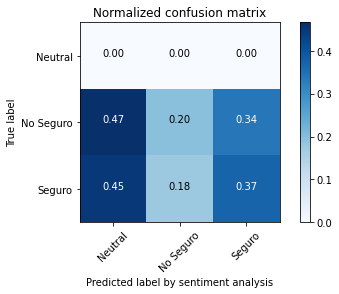

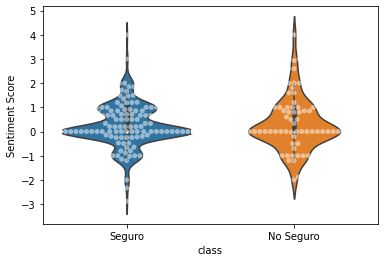

Confusion matrix, without normalization


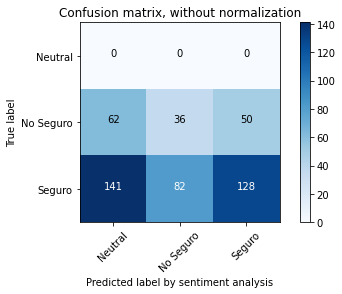

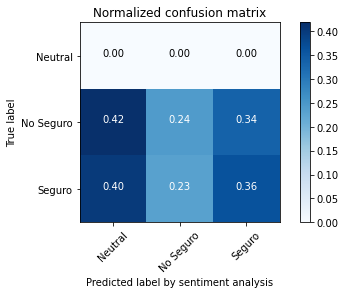

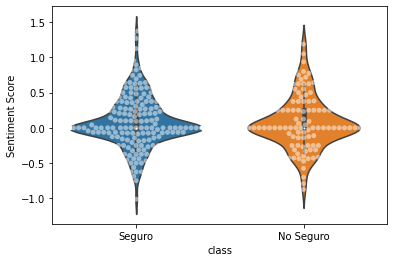

In [28]:
def computeScores(vecScoreSentimentT,dfppT):
    labels = ['Neutral','No Seguro','Seguro'];
    conMat = np.zeros((2,2));
    dfppT['Sentiment Score'] = pd.Series(vecScoreSentimentT, index=dfppT.index)
    va = (dfppT['Sentiment Score']>0);
    vb = (dfppT['class']=='Seguro');
    vaneu = np.zeros(dfppT['Sentiment Score'].shape);
    vaneu[np.where(dfppT['Sentiment Score']>0)] = 1;
    vaneu[np.where(dfppT['Sentiment Score']<0)] = 0;
    vaneu[np.where(dfppT['Sentiment Score']==0)] = -1;
    vb[vb==True] = 1;
    vb[vb==False] = 0;    
    cnf_matrix = confusion_matrix(vb, vaneu);
    if (cnf_matrix.shape[0]==2) & (cnf_matrix.shape[1]==2):
        cnf_matrix = np.matrix([[0,0,0],[0,cnf_matrix[0][0],cnf_matrix[1][0]],[0,cnf_matrix[1][1],cnf_matrix[1][1]]])        
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(cnf_matrix, classes=labels,
                          title='Confusion matrix, without normalization')

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True,
                          title='Normalized confusion matrix')
    plt.figure()
    sns.violinplot(x="class", y="Sentiment Score", data=dfppT);
    sns.swarmplot(x="class", y="Sentiment Score", data=dfppT, color="w", alpha=.5);
    plt.show()
    
computeScores(vecScoreSentimentSimple,dfpp);
computeScores(vecScoreSentimentPolarity,dfpp);